In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objs as go
import plotly.express as px


In [2]:
# Load housing data
housing_data = pd.read_csv("1553768847-housing.csv")

In [3]:
label_encoder = LabelEncoder()
housing_data['ocean_proximity'] = label_encoder.fit_transform(housing_data['ocean_proximity'])

In [4]:

# Replace missing values for total bedrooms by 0
housing_data['total_bedrooms'].fillna(0, inplace=True)


In [5]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  int64  
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.6 MB


<Axes: >

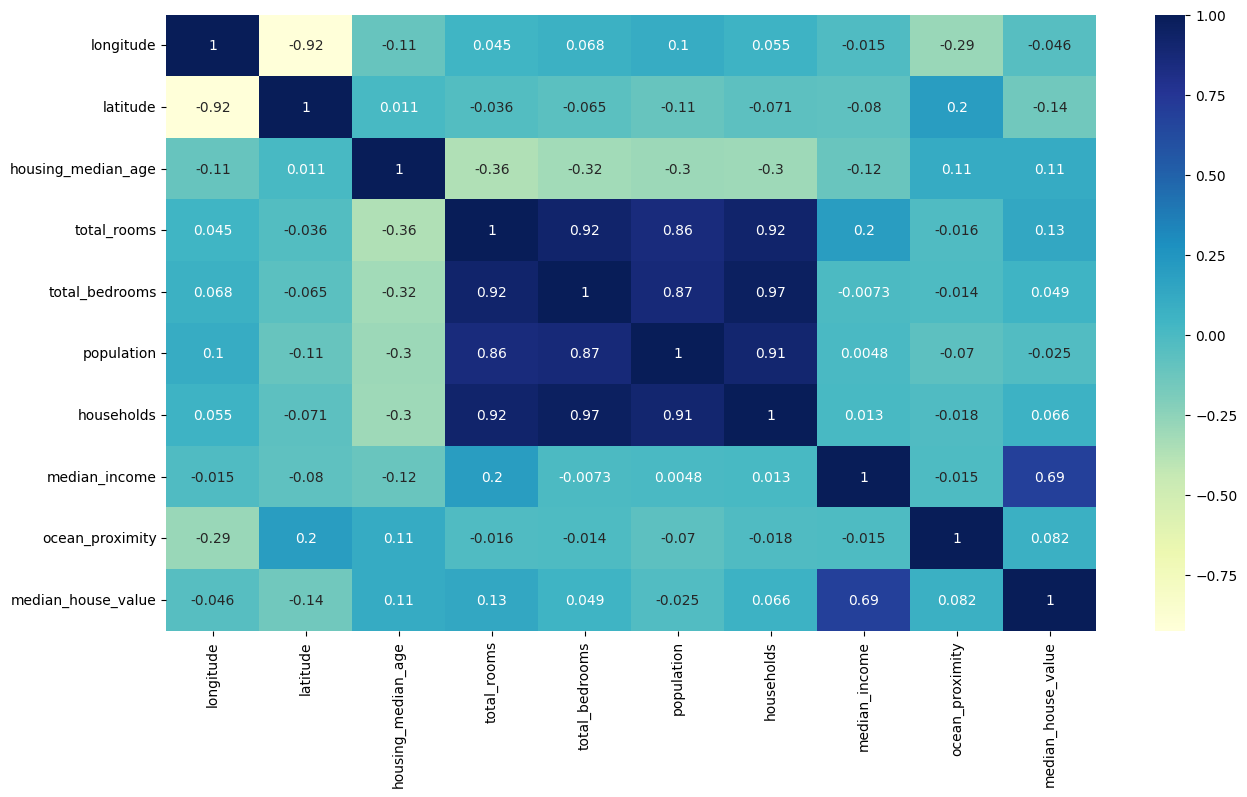

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(housing_data.corr(), annot=True, cmap="YlGnBu")



In [7]:
fig = px.imshow(housing_data.corr(), color_continuous_scale="YlGnBu")

fig.update_layout(
    title="Correlation Heatmap",
    xaxis=dict(title="Features"),
    yaxis=dict(title="Features"),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=0, r=0, b=0, t=50),
)

fig.show()

In [11]:

# Split the data into training and testing sets
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure valid column names
X_train.columns = [str(col) for col in X_train.columns]

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Hyperparameters grid search
param_grid = {
    'eta': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 9],
    'lambda': [1, 5]
}

cv_results = []

for eta in param_grid['eta']:
    for max_depth in param_grid['max_depth']:
        for lam in param_grid['lambda']:
            params = {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'eta': eta,
                'max_depth': max_depth,
                'alpha': 0.1,
                'lambda': lam
            }

            cv_model = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=100,
                nfold=5,
                early_stopping_rounds=10,
                verbose_eval=False
            )

            rmse = cv_model['test-rmse-mean'].iloc[-1]
            cv_results.append({'eta': eta, 'max_depth': max_depth, 'lambda': lam, 'rmse': rmse})

# View the results
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)

# Choose the best hyperparameters
best_params = cv_results_df.loc[cv_results_df['rmse'].idxmin()]

# Train the final model
final_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': best_params['eta'],
    'max_depth': int(best_params['max_depth']),
    'alpha': 0.1,
    'lambda': best_params['lambda']
}

final_model = xgb.train(final_params, dtrain, num_boost_round=100)

# Ensure valid column names for the test set
X_test.columns = [str(col) for col in X_test.columns]

# Evaluate the model on the test set
dtest = xgb.DMatrix(X_test)

predictions = final_model.predict(dtest)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Root Mean Squared Error on test set: {rmse}')


ValueError: feature_names must be string, and may not contain [, ] or <